# RIDGE REGRESSION e K_FOLD CV

In [2]:
import graphlab
import numpy
from matplotlib import pyplot as plt
%matplotlib inline

In [21]:
black = "\033[1;30;48m"
red = "\033[1;31;48m"
blue = "\033[1;34;48m"

In [22]:
data = graphlab.SFrame("Regression/data/kc_house_data.csv")
train_data, test_data = data.random_split(.8,seed=0)

<pre>Finished parsing file /Users/Administrator/Development/GraphLabProjects/ML/Regression/data/kc_house_data.csv</pre>

<pre>Parsing completed. Parsed 100 lines in 0.198964 secs.</pre>

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,float,int,float,int,int,float,int,int,int,int,int,int,int,int,int,float,float,int,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


<pre>Finished parsing file /Users/Administrator/Development/GraphLabProjects/ML/Regression/data/kc_house_data.csv</pre>

<pre>Parsing completed. Parsed 21613 lines in 0.322395 secs.</pre>

In [23]:
data.head()
len(data)

21613

## REGRESSION con graphlab

In [24]:
def polynomial_regression(data, l2 = 0., l1 = 0.):
    model = graphlab.linear_regression.create(data,
                                              target='price',
                                              features=['sqft_living','bedrooms','bathrooms'],
                                              l2_penalty=l2,
                                              l1_penalty=l1,
                                              validation_set=None,
                                              verbose=False)
    return model

METODI di SUPPORTO

In [25]:
def print_coefficients(model):
    grado = len(model.coefficients['value'])-1
    
    w = list(model.coefficients['value'])
    w.reverse()
    
    overfit = False
    
    for peso in w:
        if peso > 1000:
            overfit = True
        
    if overfit == False:
        print(blue + 'Grado ' + str(grado) + ':')
        print numpy.poly1d(w)
    else:
        print(red + 'Grado ' + str(grado) + ':')
        print(numpy.poly1d(w))

## CREAZIONE del MODELLO

· PROVO senza L2

In [26]:
model = polynomial_regression(train_data)
print_coefficients(model)

Grado 3:
      3             2
6942 x - 6.508e+04 x + 315.4 x + 8.791e+04


· PROVO con L2 molto PICCOLO e ricalcolo

In [27]:
model_smallL2 = polynomial_regression(train_data, l2=1e-30)
print_coefficients(model_smallL2)

Grado 3:
      3             2
6942 x - 6.508e+04 x + 315.4 x + 8.791e+04


· PROVO con diversi L2 crescenti e ricalcolo

In [35]:
for l2 in [1e-25, 1e-10, 1e-6, 1e-4, 1e-3, 1e2]:
    model = polynomial_regression(train_data, l2=l2)
    print(black + '\t\t\t\t\tL2 = %.2e' % l2)
    print_coefficients(model)
    print '---------------------------------------------------------------------------\n'

					L2 = 1.00e-25
Grado 3:
      3             2
6942 x - 6.508e+04 x + 315.4 x + 8.791e+04
---------------------------------------------------------------------------

					L2 = 1.00e-10
Grado 3:
      3             2
6942 x - 6.508e+04 x + 315.4 x + 8.791e+04
---------------------------------------------------------------------------



					L2 = 1.00e-06
Grado 3:
      3             2
6942 x - 6.508e+04 x + 315.4 x + 8.791e+04
---------------------------------------------------------------------------

					L2 = 1.00e-04
Grado 3:
      3             2
6942 x - 6.508e+04 x + 315.4 x + 8.791e+04
---------------------------------------------------------------------------



					L2 = 1.00e-03
Grado 3:
      3             2
6942 x - 6.508e+04 x + 315.4 x + 8.791e+04
---------------------------------------------------------------------------

					L2 = 1.00e+02
Grado 3:
           3             2
2.225e+04 x - 5.079e+04 x + 287.4 x + 6.574e+04
---------------------------------------------------------------------------



## LEAVE ONE OUT cross validation ~ (K_FOLD)

In [46]:
def loo(data, l2):
    
    # per velocizzare di solito num_folds = len(data)
    num_folds = len(data)/1000
    folds = graphlab.cross_validation.KFold(data, num_folds)
    
    l2_penalty_mae = []
    min_mae = None
    best_l2_penalty = None
    
    for l2_value in l2:
        next_mae = 0.0
        for train_set, validation_set in folds:
            
            model = polynomial_regression(train_set, l2=l2_value)
            
            y_test_predicted = model.predict(validation_set)
            next_mae += (abs(y_test_predicted-validation_set['price'])).sum()
        
        print("L2: ", l2_value)
        next_mae = next_mae/num_folds
        l2_penalty_mae.append(next_mae)
        if min_mae is None or next_mae < min_mae:
            min_mae = next_mae
            best_l2_penalty = l2_value
            
    return l2_penalty_mae,best_l2_penalty

Risultati e PLOT

In [54]:
# TODO set -4 to 10
l2 = numpy.logspace(-3, 7, num=10)
l2_penalty_mae,best_l2_penalty = loo(train_data, l2)

('L2: ', 0.001)


('L2: ', 0.01291549665014884)


('L2: ', 0.1668100537200059)


('L2: ', 2.1544346900318843)


('L2: ', 27.825594022071257)


('L2: ', 359.38136638046257)


('L2: ', 4641.5888336127819)


('L2: ', 59948.425031894214)


('L2: ', 774263.6826811278)


('L2: ', 10000000.0)


In [16]:
print("L2_best = ", best_l2_penalty)

('L2_best = ', 359.38136638046257)


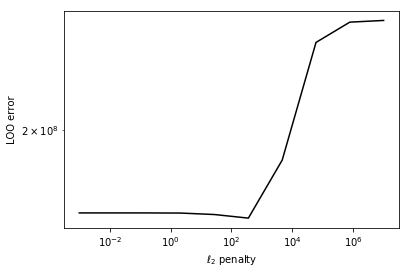

In [18]:
plt.plot(l2,l2_penalty_mae,'k-')
plt.xlabel('$\ell_2$ penalty')
plt.ylabel('LOO error')
plt.xscale('log')
plt.yscale('log')

## RIPETO la REGRESSION con il BEST L2

In [19]:
model = polynomial_regression(train_data, l2=best_l2_penalty)
print_coefficients(model)

Grado 3:
          3             2
4.39e+04 x - 2.798e+04 x + 240.2 x + 4.112e+04
